### Eval from output files
### Performance breakdown charts to see where exactly models fall short

In [1]:
import spacy
import numpy as np
from collections import Counter, defaultdict
from word2number import w2n
import string, re, json
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import random
import pickle

In [2]:
nlp = spacy.load("en_core_web_sm", disable=["ner","textcat","parser"])

In [3]:
def toNum(word):
    try: return w2n.word_to_num(word)
    except:
        return word

def normalize_text(s):
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text): # additional: converting numbers to digit form
        return " ".join([str(toNum(w)) for w in text.split()])

    def remove_punc(text):
        exclude = set(string.punctuation) - set(['.'])
        text1 = "".join(ch for ch in text if ch not in exclude)
        return re.sub(r"\.(?!\d)", "", text1) # remove '.' if it's not a decimal point

    def lower(text):
        return text.lower()
    
    def lemmatization(text):
        return " ".join([nlp(token)[0].lemma_ for token in text.split()])

    if len(s.strip()) == 1:
        # accept article and punc if input is a single char
        return white_space_fix(lower(s))
    elif len(s.strip().split()) == 1: 
        # accept article if input is a single word
        return lemmatization(white_space_fix(remove_punc(lower(s))))

    return lemmatization(white_space_fix(remove_articles(remove_punc(lower(s)))))

In [4]:
# VQA Eval (SQuAD style EM, F1)
def compute_vqa_metrics(cands, a):
    if len(cands) == 0: return (0,0,0)
    bow_a = normalize_text(a).split()
    F1 = []
    EM = 0
    RE = []
    PR = []
    for c in cands:
        bow_c = normalize_text(c).split()
        if bow_c == bow_a:
            EM = 1
        common = Counter(bow_a) & Counter(bow_c)
        num_same = sum(common.values())
        if num_same == 0:
            return (0,0,0,0,0)
        precision = 1.0 * num_same / len(bow_c)
        recall = 1.0 * num_same / len(bow_a)
        RE.append(recall)
        PR.append(precision)

        f1 = 2*precision*recall / (precision + recall + 1e-5)
        F1.append(f1)
    
    PR_avg = np.mean(PR)
    RE_avg = np.mean(RE)
    F1_avg = np.mean(F1)
    F1_max = np.max(F1)
    return (F1_avg, F1_max, EM, RE_avg, PR_avg)

In [73]:
def get_guid2metrics_from_model_output(input_json, model_output_json, guid2metrics=defaultdict(lambda: {}), beam=5):
    split_json = json.load(open(input_json, "r"))
    split = model_output_json.split("/")[-1].split("_")[0]
    if 'd' in split: split += "_test"
    guids = [split_json[k]['Guid'] for k in split_json if split_json[k]['split'] == split]
    Qcates = [split_json[k]['Qcate'] for k in split_json if split_json[k]['split'] == split]
    Qtypes = [split_json[k]['Qtype'] for k in split_json if split_json[k]['split'] == split]
    with open(model_output_json, "r") as f:
        lines = f.readlines()
    while True:
        if lines[0].strip() == "-----Starting writing results:-----":
            lines.pop(0)
            lines.pop(0)
            break
        else:
            lines.pop(0)

    pt = 'Q'
    
    folder = {'Q':[], 'A':[], 'C':[], 'TopC':[]}
    for l in lines:
        if pt == 'Q':
            folder[pt].append(l.strip())
            pt = 'A'
        elif pt == 'A':
            folder[pt].append(l.strip())
            pt = 'OC'
        elif pt == 'OC': # Output Confidence
            pt = 'C'
            folder[pt].append([])   
        elif pt == 'C':
            folder[pt][-1].append(l.strip())
            if len(folder[pt][-1]) == beam:
                folder['TopC'].append([folder[pt][-1][0]])
                pt = ''
        else:
            pt='Q' # skip empty line between samples
    assert len(folder['Q']) == len(folder['A']) == len(folder['C']) == len(folder['TopC']) == len(guids)
    
    for q, a, topc, guid, Qcate, Qtype in zip(folder['Q'], folder['A'], folder['TopC'], guids, Qcates, Qtypes):
        F1_avg, F1_max, EM, RE, PR = compute_vqa_metrics(topc, a)
        if guid in guid2metrics:
            guid2metrics[guid]['F1'].append(F1_avg)
            guid2metrics[guid]['EM'].append(EM)
            guid2metrics[guid]['RE'].append(RE)
            guid2metrics[guid]['PR'].append(PR)
            guid2metrics[guid]['C'].append(topc[0])
        else:
            guid2metrics[guid] = {'F1':[F1_avg], 'EM': [EM], 'RE': [RE], 'PR': [PR], 'Q': q, 'A': a, 'C': [topc[0]], 'Qcate': Qcate, 'Qtype': Qtype}
    print(len(folder['Q']))
    


In [67]:
def plot_metrics_breakdown_by_Qcate(guid2metrics, metric, title='Performance breakdown by Qcate'):
    cates = ['YesNo', 'choose', 'number', 'color', 'shape', 'Others']
    metrics_by_cates = []
    for c in cates:
        metrics_by_cates.append([guid2metrics[guid][metric][0] for guid in guid2metrics if guid2metrics[guid]['Qcate'] == c])
    fig, axes = plt.subplots(2, 3, sharex=True, figsize=(15,6))
    fig.suptitle(title + ", metric = {}".format(metric))
    i = 0
    for data, c, color in zip(metrics_by_cates, cates, sns.color_palette("Set2")):
        ax = axes[i//3, i%3]
        sns.histplot(data, ax=ax, bins=10, kde=False, label=c, color=color)
        ax.legend()
        ax.set_xlim(0, 1)
        i += 1


In [69]:
def plot_metrics_breakdown_by_Qtype(guid2metrics, metric, title='Performance breakdown by Qtype'):
    types = ['img-Multihop', 'img-Singlehop']
    metrics_by_types = []
    for c in types:
        metrics_by_types.append([guid2metrics[guid]['F1'][0] for guid in guid2metrics if guid2metrics[guid]['Qtype'] == c])
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
    fig.suptitle(title + ", metric = {}".format(metric))
    i = 0
    for data, c, color in zip(metrics_by_types, types, sns.color_palette("Set2")):
        ax = axes[i]
        sns.histplot(data, ax=ax, bins=10, kde=False, label=c, color=color)
        ax.legend()
        ax.set_xlim(0, 1)
        i += 1


In [27]:
input_json = "/home/yingshac/CYS/WebQnA/WebQnA_data_new/dataset_J_split_finalized0629.json"
model_output_json = "/home/yingshac/CYS/WebQnA/VLP/vlp/light_output/qa_img_split_finalize/qa_infr/ood_test_qainfr_-1_beam5_img_True_True_step10_dataset_J_split_finalized0629.txt"
guid2metrics_ood = defaultdict(lambda: {}) 
get_guid2metrics_from_model_output(input_json, model_output_json, guid2metrics_ood)

3987


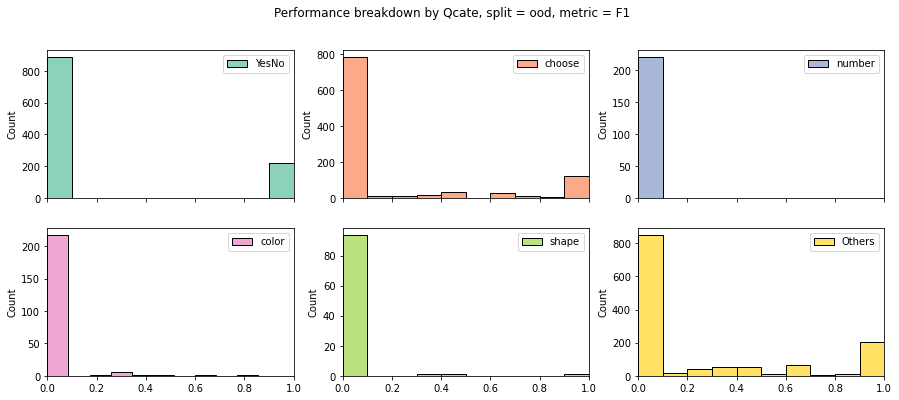

In [71]:
plot_metrics_breakdown_by_Qcate(guid2metrics_ood, 'F1', "Performance breakdown by Qcate, split = ood")

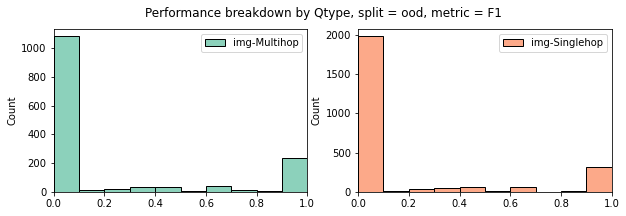

In [72]:
plot_metrics_breakdown_by_Qtype(guid2metrics_ood, 'F1', "Performance breakdown by Qtype, split = ood")

In [54]:
count = 0
for guid in guid2metrics_ood:
    if not guid2metrics_ood[guid]['Qcate'] == 'choose': continue
    x = np.max(guid2metrics_ood[guid]['F1'])
    if x > 0:
        if random.random() < 1:
            print(guid, guid2metrics_ood[guid]['F1'])
            print(guid2metrics_ood[guid]['Q'])
            print(guid2metrics_ood[guid]['A'])
            print(guid2metrics_ood[guid]['C'])
            print()
        count += 1
print(count)

dc444518d46f11ebba07a504a20e7724 [0.9999950000249999]
If facing midtown Manhattan , is the Chrysler building to the right or left of the Empire State building ?
Right
['right']

dc45d00ed46f11ebba07a504a20e7724 [0.9999950000249999]
Do the words on the plaque for the statue of Pierre de Coubertin in Centennial Olympic Park in downtown Atlanta form a full circle or a semicircle ?
Semicircle
['semicircle']

dc493ff0d46f11ebba07a504a20e7724 [0.9999950000249999]
Which mushroom has the flatter cap , the Hedgehog mushroom or the Peziza ?
The Hedgehog mushroom .
['Hedgehog mushroom']

dc497d26d46f11ebba07a504a20e7724 [0.24999500009999803]
Is the head of the Johnson Acoustic Electric Guitar or the Parker NiteFly - M guitar wider ?
Johnson Acoustic Electric Guitar
['Parker NiteFly - M guitar .']

dc499decd46f11ebba07a504a20e7724 [0.9999950000249999]
Does the Geastrum triplex mushroom have an even or uneven shape overall ?
Uneven
['uneven']

dc49a670d46f11ebba07a504a20e7724 [0.9999950000249999]
W

In [74]:
input_json = "/home/yingshac/CYS/WebQnA/WebQnA_data_new/dataset_J_split_finalized0629.json"
model_output_json = "/home/yingshac/CYS/WebQnA/VLP/vlp/light_output/qa_img_split_finalize/qa_infr/val_qainfr_-1_beam5_img_True_True_step10_dataset_J_split_finalized0629.txt"
guid2metrics_val = defaultdict(lambda: {}) 
get_guid2metrics_from_model_output(input_json, model_output_json, guid2metrics_val)

2514


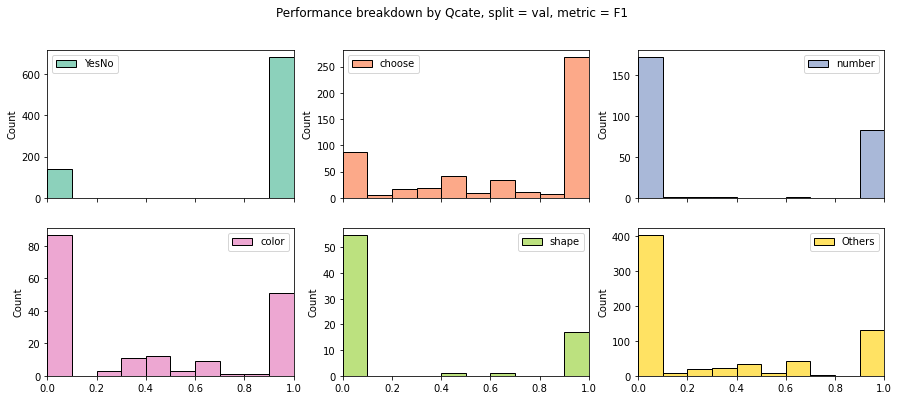

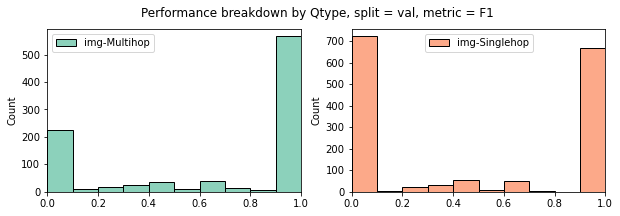

In [75]:
plot_metrics_breakdown_by_Qcate(guid2metrics_val, 'F1', "Performance breakdown by Qcate, split = val")
plot_metrics_breakdown_by_Qtype(guid2metrics_val, 'F1', "Performance breakdown by Qtype, split = val")

In [88]:
count = 0
for guid in guid2metrics_val:
    if not guid2metrics_val[guid]['Qcate'] == 'shape': continue
    x = np.max(guid2metrics_val[guid]['F1'])
    if x == 0 :
        if random.random() < 0.1:
            print(guid, guid2metrics_val[guid]['F1'])
            print(guid2metrics_val[guid]['Q'])
            print(guid2metrics_val[guid]['A'])
            print(guid2metrics_val[guid]['C'])
            print()
        count += 1
print(count)

dc4536f8d46f11ebba07a504a20e7724 [0]
What shaped structures are found a the bottom of the steps of the Bethesda Terrace ?
Arches
['square']

dc681470d46f11ebba07a504a20e7724 [0]
What shape are the windows on the second floor of the Bin Dawood Nabawi Mosque ?
Arched .
['Rectangles']

dc6d0d40d46f11ebba07a504a20e7724 [0]
In what shape are the petals of the flower of the Camellia Japonica arranged ?
Star
['Rounded .']

dc6e575ed46f11ebba07a504a20e7724 [0]
What shape is the base of the statue in the Darlington Memorial Fountain .
An octagon .
['']

55
